# K-En Yakın Komşu (K-Nearest Neighbors)

Gözlemlerin birbirlerine olan benzerlikleri üzerinden tahmin yapılır. Hem regresyon problemleri için, hem de sınıflandırma problemleri için kullanılabilir.

### K-Nearest Neighbors Regression

Regresyon problemlerinde, dışarıdan girilen değerler ile bağımlı değişken hesaplamak için bu gözlem birimine en yakın 5 tane komşunun (ne kadar girildiyse o kadar komşunun) bağımlı değişkenlerinin ortalamaları alınarak o gözlemin bağımlı değişkeni hesaplanır.

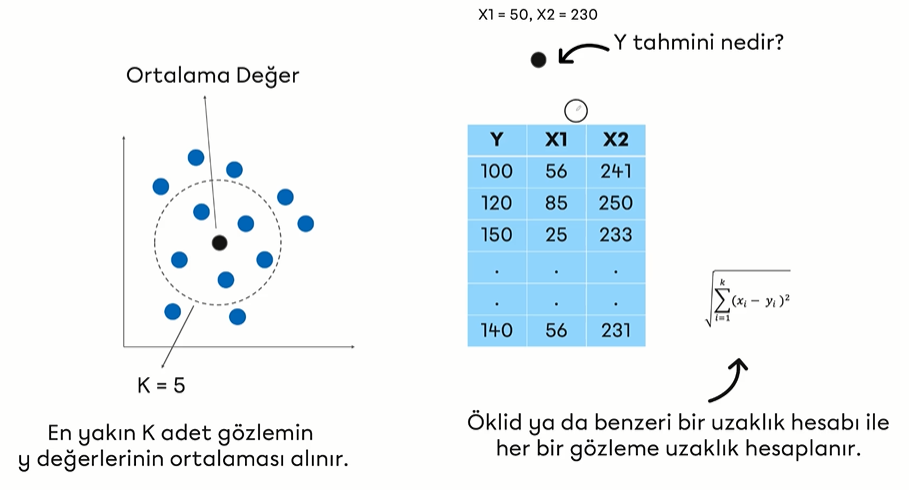

Dışarıdan girdiğimiz gözleme en yakın noktaları bulmak için bir uzaklık hesabı yapmamız gerekiyor. Bunun için bir çok denklem var ama en sık kullanılan Öklid'dir. Öklid ile bağımsız değişkenlerden bir uzaklık hesaplanır, böylece dışarıdan girilen gözleme en yakın olan komşular belirlenir. Model kurulurken komşu sayısı ne kadar girilmişse o kadar komşunun bağımlı değişkenlerine bakılır ve en sonunda bu bağımlı değişkenlerin ortalamaları, yeni gözleme atanır. Böylece tahmin yapılmış olur.

### K-Nearest Neighbors Classification

Sınıflandırma problemlerinde de işlemler hemen hemen aynı şekilde yapılır. Fakat burada farklı olarak en son tahmin yapılırken, ilgili gözlem birimine yakın komşularından çoğunlukta olan sınıf hangisi ise, o gözlem biriminin bağımlı değişkeni de o sınıf olarak tahmin edilir.

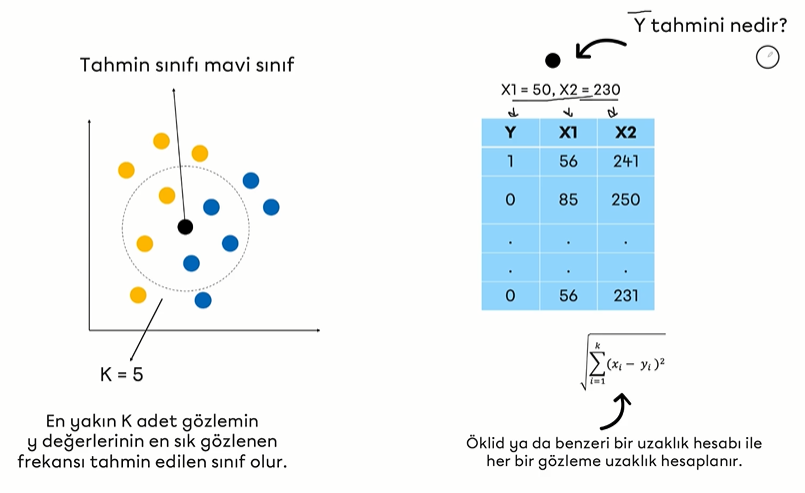

Yine aynı şekilde, gözlem birimlerinin bağımsız değişkenlerinden, öklid denklemi ile uzaklıkları hesaplanır. Bu uzaklıklar ile dışarıdan girilen gözlemin komşuları belirlenir. Modeli kurarken girdiğimiz komşu miktarı kadar komşunun bağımlı değişkenlerine bakılır. Tahmin edecek olduğumuz gözlem biriminin çevresinde en çok hangi sınıf varsa, o gözlem birimi de o sınıfa dahil edilir.

## Örnek Proje Çözümü

Bu kısımda diyabet veri setini kullanacağız. Bağımlı değişken ("Outcome") diyabet hastalığına sahip olma veya olmamayı ifade ediyor. Model kısmına daha çok odaklanmak adına keşifçi veri analizi ve data preprocessing & feature engineering kısımlarının üzerinde çok durmayacağız (Sonrası için farklı çalışmalar yapılabilir).

In [60]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

### Keşifçi Veri Analizi (EDA)

In [61]:
df = pd.read_csv('datasets/diabetes.csv')

In [62]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [63]:
df.shape

(768, 9)

In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [65]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

### Veri Ön İşleme (Data Preprocessing) & Feature Engineering

In [66]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

Kullanacak olduğumuz KNN yöntemi uzaklaklık temelli bir yöntem. Uzaklık temelli yöntemlerde ve gradient descent temelli yöntemlerde değişkenlerin standart olması elde edilecek sonuçların ya daha hızlı ya da daha doğru olmasını sağlayacaktır. Bundan dolayı elimizdeki bağımsız değişkenleri standartlaştırma işlemine sokuyor olacağız.

In [67]:
X_scaled = StandardScaler().fit_transform(X)

Değişkenleri standartlaştırdık fakat yukarıdaki koddan bize bir numpy array dönecek.

In [68]:
X_scaled

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]])

Verilerimiz bu şekilde hiçbir bilgi taşımıyorlar. Bundan dolayı bu verileri bir dataframe içerisine alıp kolonlarını eklememiz gerekiyor.

In [69]:
X = pd.DataFrame(X_scaled, columns=X.columns)

In [70]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496


### Modeling & Prediction

In [71]:
knn_model = KNeighborsClassifier().fit(X, y)

In [72]:
random_user = X.sample(1, random_state=45)

Modeli kurduk ve X veri setinden rastegele bir kişi seçtik. Şimdi bu kişiyi modele verip bir tahmin alalım.

In [73]:
knn_model.predict(random_user)

array([1], dtype=int64)

### Model Evaluation

In [74]:
# confusion matrix için y_pred
y_pred = knn_model.predict(X)

AUC değerini hesaplamamız için ROC eğrisini kullanmamız gerekiyor. Classification threshold'ları değiştirerek bu farklı değerler üzerinden true positive rate ve false positive rate değerlerine göre ROC eğrisi oluşturulur ve bu eğrinin altında kalan alan yani AUC hesaplanır. Bu değerinde hesaplanabilmesi için tahmin değerleri yerine, 1 sınıfına ait olma olasılıkları lazım. Dolayısıyla bunun için olasılık değerlerini hesaplamamız gerekiyor.

In [75]:
# AUC için y_prob
y_prob = knn_model.predict_proba(X)[:, 1]

In [76]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       500
           1       0.79      0.70      0.74       268

    accuracy                           0.83       768
   macro avg       0.82      0.80      0.81       768
weighted avg       0.83      0.83      0.83       768



Yukarıdaki sonuçları incelediğimizde accuracy değerimiz 0.83 olarak hesaplanmış. Yani bu, yapılan tahminlerin %83'ü doğru tahmin demek. Fakat dengesiz veri setlerinde accuracy üzerinden yorum yapmak her zaman doğru olmayabilir. Bundan dolayı precision, recall ve f1-score sonuçlarını da göz önünde  bulundurmamız gerekli. 

Precision, 1 olarak tahmin ettiklerimizin ne kadarının doğru olduğunu, recall ise gerçek 1 sınıfına ait olanların ne kadarını doğru tahmin ettiğimizi gösteren bir sonuçtur. f1-score ise bu iki sonucun harmonik ortalamasıdır. Yani f1 score'a baktığımızda, acccuracy'deki çıkan sonuç kadar başarılı olmadığımızı, ama yine de %70'in üzerinde bir sonuç elde ettiğimizden dolayı fena olmayan bir sonuç elde ettiğimiz yorumunu yapabiliriz.

In [77]:
# AUC
roc_auc_score(y, y_prob)

0.9017686567164179

AUC skorumuz da %90 çıktı. Oldukça yüksek ve iyi bir değer. 

Burada modeli kurmak için kullandığımız veri seti ile modeli değerlendirmek için kullandığımız veri setleri aynı. Dolayısıyla şimdi de cross validation yöntemini kullanarak yeni bir model kuracağız ve yeni modelin sonuçları ile eski modelin sonuçlarını karşılaştıracağız.

Bunun için cross_validate metodunu kullanacağız. Farklı olarak cross_val_score metodu da bulunmakta. cross_validate metodunun cross_val_score'dan farkı, birden fazla metriğe göre de değerlendirme yapabiliyor olmasıdır. 

In [78]:
cv_results = cross_validate(knn_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [79]:
cv_results

{'fit_time': array([0.00899267, 0.0069983 , 0.01065326, 0.00799441, 0.00799584]),
 'score_time': array([0.03797913, 0.0232935 , 0.02835321, 0.03128552, 0.02398491]),
 'test_accuracy': array([0.72077922, 0.73376623, 0.71428571, 0.77124183, 0.7254902 ]),
 'test_f1': array([0.58252427, 0.60952381, 0.54166667, 0.63917526, 0.58      ]),
 'test_roc_auc': array([0.77555556, 0.78759259, 0.73194444, 0.83226415, 0.77528302])}

5 katlı çapraz doğrulama yaptığımızdan için veri setini 5'e böldü. 4'ü ile model kurdu 1'i ile test etti. Her 5 parçanın da model ve test için kullanılmasıyla elimizde 5 farklı accuracy, f1 ve roc_auc skorları bulunuyor. Dolayısıyla bu skorların ortalamasını aldığımızda 5 katlı çapraz doğrulamanın bütün test skorlarının ortalamasını almış olacağız.

In [80]:
print("5K_CV Accuracy:", cv_results['test_accuracy'].mean())
print("5K_CV F1:", cv_results['test_f1'].mean())
print("5K_CV ROC_AUC:", cv_results['test_roc_auc'].mean())

5K_CV Accuracy: 0.733112638994992
5K_CV F1: 0.5905780011534191
5K_CV ROC_AUC: 0.7805279524807827


Önceki sonuçlarımız da;

- Accuracy: 0.83
- F1: 0.74 
- ROC_AUC: 0.9017686567164179

Modeli kurduğumuz veriyi, modeli değerlendirirken de kullandığımızda ortaya bir miktar yanlılık çıktı. Bu yanlılık, sonuçları doğru değerlendirmemizi engeller. Cross validation ile aldığımız sonuçlar ne kadar diğerinden daha başarısız olsa da, buradaki sonuçlar çok daha güvenilirdir. Bize hangi noktada olduğumuzla ilgili daha iyi bilgi verir.

Peki bu başarı skorları nasıl arttırılabilir?

1. Gözlem sayısı arttırılabilir.
2. Veri ön işleme işlemleri detaylandırılabilir.
3. Özellik mühendisliği - yeni değişkenler türetilebilir.
4. İlgili algoritma için optimizasyonlar yapılabilir.

Parametre, veri içerisinden öğrenilmektedir. Hiperparametre ise kullanıcı tarafından tanımlanması gereken dışsal ve veri seti içerisinden öğrenilemeyen parametrelerdir. KNN algoritmasında da birçok hiperparametre bulunmaktadır. Dolayısıyla modeli kurarken komşuluk sayısı hiperparametresi vereceğiz, bunları tek tek deneyip denemeler neticesinde hatalarımıza bakıp, böylece normalde veriden öğrenilemeyen kullanıcı tarafından verilmesi gereken bu hiperparametreleri bir set olarak gönderip bunlar sonucunda en düşük hatayı veren hiperparametre setini nihai olarak görebiliriz. 

### Hyperparameter Optimization

In [81]:
knn_model = KNeighborsClassifier()

In [82]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Yukarıdaki kod ile, knn algoritmasında kullanabileceğimiz parametreleri görebiliriz. Bu parametler içerisinde n_neighbors adında komşuluk sayısını belirleyen bir parametre bulunuyor. Amacımız, komşuluk sayısını değiştirerek olması gereken en optimum komşuluk sayısının ne olacağını bulmak. Bunun için bir parametre listesi oluşturmamız gerekiyor.

In [83]:
knn_params = {"n_neighbors": range(2, 50),
             "weights": ['uniform', 'distance'],
             "metric": ['euclidean', 'minkowski', 'manhattan']}

In [84]:
knn_gs_best = GridSearchCV(knn_model, 
                           knn_params, 
                           cv=5,  
                           n_jobs=-1, 
                           verbose=1).fit(X, y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   20.8s finished


In [85]:
knn_gs_best.best_params_ # en iyi sonuçları göster

{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}

Sonucumuza göre en düşük hatayı veren komşuluk sayımız 17imiş. Şimdi final modelimizi kurup parametre olarak da yukarıda bulduğumuz parametreleri gireceğiz.

### Final Model

In [86]:
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X, y)

Modeli en iyi parametreler ile kurduk. Şimdi modelin test hatalarına bakmamız gerekiyor.

In [87]:
cv_results = cross_validate(knn_final,
                           X,
                           y,
                           cv=5,
                           scoring=["accuracy", "f1", "roc_auc"])

In [88]:
print("Accuracy:", cv_results['test_accuracy'].mean())
print("F1:", cv_results['test_f1'].mean())
print("ROC_AUC:", cv_results['test_roc_auc'].mean())

Accuracy: 0.7747984042101688
F1: 0.6154765082418827
ROC_AUC: 0.8191974143955276
